# Python Statelevel fitVirusXX
## Version 10.X
## Date: 01.25.2021
## Author: Azmyin Md. Kamal
## For the Association Mining Paper / Mobility paper
## This version will allow starting the incidence of 2nd wave from a location within first wave

# Load Preambles

In [1]:
# Big idea, run this cell only once
# Load all modules, function definitions and important variable definitions
from funcsXX import *

df = pd.read_csv("Cases_All.csv", header = 0) # Master
#df.head(10)

# Keep week array in memory
week_array_file = df['week'].values

# Store incidence values
df_master = pd.DataFrame()
#df_master['Week'] = week_array_file
#df_master.head(10) # Debug

# Store phase week values
df_master_2 = pd.DataFrame()
df_master_2['Phase Loc'] = ['w1_tp2','w1_tpeak','w1_tp3','w1_tp4','w1_tpend','w2_tp2','w2_tpeak','w2_tp3','w2_tp4','w2_tpend']
#df_master_2.head(10) # Debug

# Store cumulative values
df_master_3 = pd.DataFrame()

const_add = week_array_file[0] - 1
size_fig = (20,5)

In [140]:
df = pd.read_csv("Cases_All.csv", header = 0) # Master
#df.head(10)

In [2]:
# Function that takes in the primary dataframe, name of a state and outputs week level cases and an array for counting week
def choose_state(df, state_name):
    sampleC = np.asarray(df[state_name])
    
    # We assume that we have at least 1 infected person in first day of outbreak
    if (sampleC[0] <= 0):
        sampleC[0] = 1
    
    week_agg = np.asarray(sampleC).reshape(-1)
    timestamp_week = np.asarray([(i+1) for i in range(len(sampleC))])
    return week_agg, timestamp_week

# Master plotting function
# Also has 
def plot_fit(plot_title, y_act, y_pred, t_cumu, size_tup):
    # plot-title is a string
    
    fig = plt.figure(figsize=size_tup)
    plt.scatter(t_cumu, y_act, color = 'red', label = 'Actual')
    plt.plot(t_cumu, y_pred, color = 'blue', label = 'Model')
    plt.title(plot_title)
    #plt.show()
    # Plot legends will go in here later


def fit_single_phase(bb_fit1, t_span_w1, print_res = False):
    w1_tpeak, w1_tp2, w1_tp3, w1_tp4, w1_tpend = 0,0,0,0,0
    w1_loc_ls = []

    # Unpack variables for wave 1
    w1_K = bb_fit1[0]
    w1_r = bb_fit1[1]
    w1_A = bb_fit1[2]

    w1_loc_ls = find_phase_loc(w1_K, w1_r, w1_A, t_span_w1, print_res)
    return w1_loc_ls


def fit_incidence_single(y_act, t_cumu, param_w1):
    P_act_w1 = y_act
    tt_w1 =  t_cumu
    I_act_w1 = np.diff(P_act_w1)
    I_act_w1 = np.insert(I_act_w1, [0], [I_act_w1[0]])
    I_pred_w1 = logisticFun2(tt_w1, param_w1, P_act_w1)

    return I_act_w1, I_pred_w1

def fit_waveX(b00, week_agg, tspan, show_rep, method):
    # Define working variables
    b = []
    y_hat = []
    method_user = method
    P_week = week_agg
    tt_span = tspan

    fit_params = Parameters() # Define Parameter class from LMFIT

    if len(b00) == 0:
        fit_params.add('K', value= max(P_week), max = 10000000)
        fit_params.add('r', value= 0.5, min = 0.1, max = 50.0)
        #fit_params.add('r', value= 0.5)
        fit_params.add('A', value = max(P_week), max = 10000000)
    else:
        KK = b00[0]
        rr = b00[1]
        AA = b00[2]
        fit_params.add('K', value= KK, max = 10000000)
        fit_params.add('r', value= rr, min = 0.1, max = 50.0)
        #fit_params.add('r', value= 0.5)
        fit_params.add('A', value = AA, max = 10000000)

    # Here we will get the fit
    # method -- nedler, monte-carlo, leastsq
    fit_yy = minimize(objFun, fit_params, args=(tt_span,), kws={'data': P_week}, method = method_user)
    
    if (show_rep == True):
        print(fit_report(fit_yy))
    
    # Extract results
    Kopt = fit_yy.params['K'].value
    ropt = fit_yy.params['r'].value
    Aopt = fit_yy.params['A'].value

    b_fit = [Kopt, ropt, Aopt]
    
    # Calcuate predicted values
    y_hat = logisticFun(tt_span,b_fit)

    return b_fit, y_hat


def check_multiwaveX(b00, week_agg, tspan):
    # Load working variables
    y_act = week_agg # To avoid local variable referenced before problem
    t_cumu = tspan
    size_tup = (15,5) # Size of graph
    
    # Pass initial guess values or take values fitted from last wave
    if len(b00) == 0:
        b01 = iniGuessX(y_act)
    else:
        b01 = b00 # Take values from last wave
    
    # Search for best method
    method_names = ['least_sqaures', 'nelder', 'leastsq', 'cg', 'bfgs', 'dual_annealing', 'lbfgsb']
    mm_final = []

    # Run loop
    for kk in method_names:
        y_pred = [] # Clean up for each iteration
        b_fit, y_pred = fit_waveX(b01, y_act, t_cumu, show_rep = False, method = kk)
        rr_temp = calcR2(y_act, y_pred)
        rr_temp = round(rr_temp, 2)
        print(f"\nMethod --> {kk}, bb_fit2 --> {b_fit}, R2 --> {rr_temp}\n")

        if ((rr_temp> 0.80 and rr_temp<=0.99) or (rr_temp == 1.0)):
            #print(f"\nMethod {kk} gives acceptable fit")
            mm_final = kk
            print(f"\nMethod chosen --> {kk}\n")
            break
        else:
             # We don't have a choice so go with least_squares
             mm_final = 'least_squares'

    # Perform fit with best method
    b_fit = [] 
    y_pred = []
    b_fit, y_pred = fit_waveX(b01, y_act, t_cumu, show_rep = False, method = mm_final)

    # Calcualte scores
    rr2, rmse_score = calcStats(y_true = y_act, y_pred=y_pred, print_debug = False)
    print(f"R2 score with best fit --> {rr2}\n")
    print(f"RMSE score with best fit --> {rmse_score}\n")
        
    return b_fit, y_pred

# Main code

In [147]:
# Original algorithm
state_names = ['Wyoming'] # One state at a time
man_idx = 28 # Human judgment on where wave 1 ends
look_back = 10 # A parameter which shows how far back we look back into wave 1 (considered fixed)
man_idx_2 = man_idx - look_back # number of weeks to look back behind wave 1 end

state_name = state_names[0]
# Read week aggregate and cumulative
week_agg, t_cumu = choose_state(df, state_name)

# find phase loc outputs in my scale
tol_wave = 0.97
I_pred = []
I_act = []
y_act = []
y_pred = []
plot_res = True
print_res = False
# ------------------------ HUMAN JUDGEMENT PARAMETERS ---------------------------


Method --> least_sqaures, bb_fit2 --> [6778.785409845529, 0.17205193288520226, 174.80061438302178], R2 --> 0.99


Method chosen --> least_sqaures

R2 score with best fit --> 0.99

RMSE score with best fit --> 91.14325340499975


Start loc wave --> 1
tp2 --> 19
tpeak --> 30
tp3 --> 28
tp4 --> 0
tpend --> 0


Method --> least_sqaures, bb_fit2 --> [9999999.999598673, 0.19238074550813866, 1657061.0564239188], R2 --> 0.98


Method chosen --> least_sqaures

R2 score with best fit --> 0.98

RMSE score with best fit --> 1079.7797603837262


Start loc wave --> 19
tp2 --> 64
tpeak --> 74
tp3 --> 44
tp4 --> 0
tpend --> 0

w2_phases after taking weeks from wave 1 --> [44, 44, 44, 0, 0]


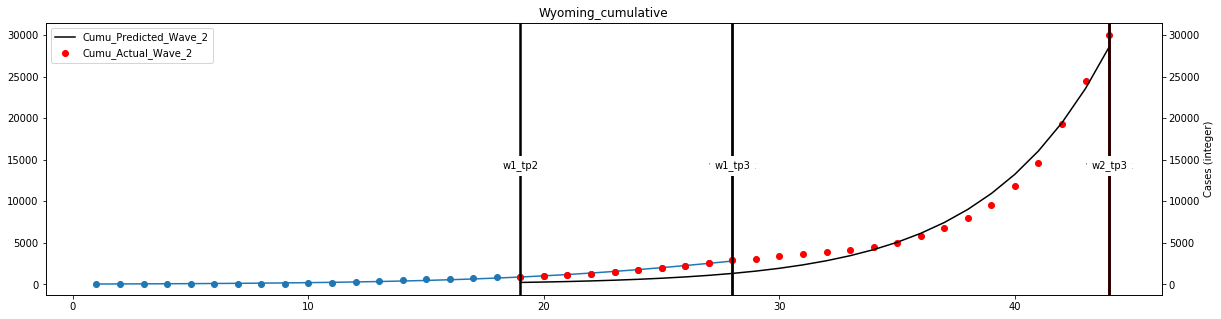

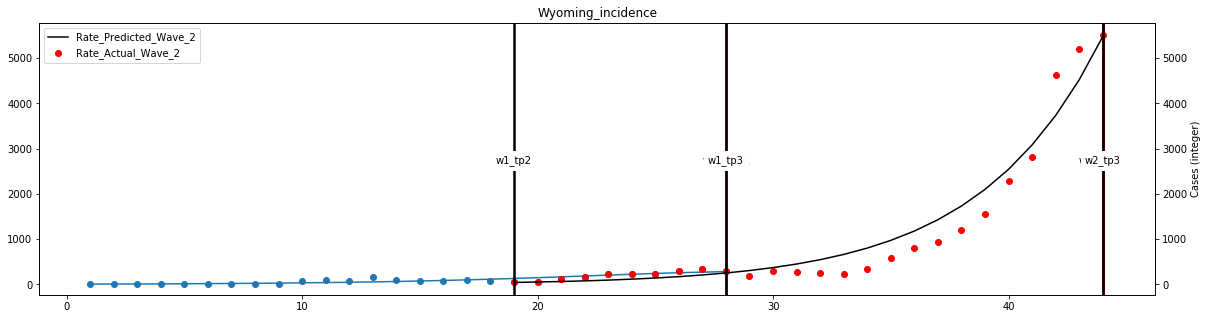

In [148]:
# Split data
P_w1 = week_agg[:man_idx]
t_w1 = t_cumu[:man_idx] # My scale
t_w1_max_scale = max(t_w1)
t_w1_scaled = week_array_file[:man_idx] # Actual scale

P_w2 = week_agg[(man_idx_2):]
t_w2 = t_cumu[(man_idx_2):]
t_w2_max_scale = max(t_w2)
t_w2_scaled = week_array_file[(man_idx_2):]

# Fit first wave, check_multiwaveX is a name typo
b0_init = [] # We don't have any initial values to pass for first wave test
b_wave1, y_pred_w1 = check_multiwaveX(b00 = b0_init, week_agg = P_w1, tspan = t_w1)

# Find incidence for first wave
I_act_w1, I_pred_w1 = fit_incidence_single(y_act=P_w1, t_cumu=t_w1, param_w1=b_wave1)

# Find phases for first wave
w1_loc = fit_single_phase(bb_fit1 = b_wave1, t_span_w1 = t_w1, print_res = True)

# Scale to correct scale
w1_loc = scale_to_dat_week(w1_loc, const_add, t_w1_max_scale)

# Fit 2nd wave with adjusted data
b0_init = [] # We don't have any initial values to pass for first wave test
b_wave2, y_pred_w2 = check_multiwaveX(b00 = b0_init, week_agg = P_w2, tspan = t_w2)

## Find incidence for 2nd wave with adjusted dataset
I_act_w2, I_pred_w2 = fit_incidence_single(y_act=P_w2, t_cumu=t_w2, param_w1=b_wave2)

# Find 2nd wave phases
w2_loc = fit_single_phase(bb_fit1 = b_wave2, t_span_w1 = t_w2, print_res=True) 
# Scale to correct scale
w2_loc = scale_to_dat_week(w2_loc, const_add, t_w2_max_scale)
max_y = max(I_pred_w2)
print(f"w2_phases after taking weeks from wave 1 --> {w2_loc}") # Debug

# Recombine cumulative cases values
y_act = week_agg
y_pred = np.concatenate((y_pred_w1, y_pred_w2))

# Recombine piecewised actual change in cases array
I_act = np.concatenate((I_act_w1, I_act_w2))
I_pred = np.concatenate((I_pred_w1, I_pred_w2)) 
t_cumu = np.concatenate((t_w1, t_w2))

import os
# my_path = os.getcwd()
# my_path = os.path.join(my_path, "\\figs")
#out_path = os.path.join("C:\Users\azmyi\OneDrive - University of Louisiana Lafayette\Dr. Raju\COVID paper\multi_peak_overlap_allowed_1.25.2021","\figs")

out_path = r"C:\Users\azmyi\OneDrive\Desktop\figs"

# Draw plots -- PREVELANCE
fig, ax1 = plt.subplots(figsize = (20,5))
color = 'tab:blue'
ax1.scatter(t_w1, P_w1, label = "Cumu_Actual_Wave_1")
ax1.plot(t_w1, y_pred_w1, label = "Cumu_Predicted_Wave_1")
ymin1, ymax1 = ax1.get_ylim()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(t_w2, P_w2, color = 'red', label = "Cumu_Actual_Wave_2")
ax2.plot(t_w2, y_pred_w2, color = 'black', label = "Cumu_Predicted_Wave_2")
ymin2, ymax2 = ax2.get_ylim()
miny = min(ymin1, ymin2)
maxy = max(ymax1, ymax2)
ax1.set_ylim([miny, maxy])
ax2.set_ylim([miny, maxy])
# Plot phase lines
max_y_act = max(y_pred)
plot_phase_lines(w1_loc, w2_loc, max_y_act)
pname = state_name + "_cumulative"
plt.title (pname)
plt.xlabel("Time (weeks)")
plt.ylabel("Cases (integer)")
plt.legend()
plt.savefig(os.path.join(out_path, pname))
#plt.savefig("\\figs" + pname)

# -------------------------------------------------------------------------

# Draw plots -- INCIDENCE
fig, ax1 = plt.subplots(figsize = (20,5))
color = 'tab:blue'
ax1.scatter(t_w1, I_act_w1, label = "Rate_Actual_Wave_1")
ax1.plot(t_w1, I_pred_w1, label = "Rate_Predicted_Wave_1")
ymin1, ymax1 = ax1.get_ylim()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.scatter(t_w2, I_act_w2, color = 'red', label = "Rate_Actual_Wave_2")
ax2.plot(t_w2, I_pred_w2, color = 'black', label = "Rate_Predicted_Wave_2")
ymin2, ymax2 = ax2.get_ylim()
miny = min(ymin1, ymin2)
maxy = max(ymax1, ymax2)
ax1.set_ylim([miny, maxy])
ax2.set_ylim([miny, maxy])
# Plot phase lines
max_y_act = max(I_pred)
plot_phase_lines(w1_loc, w2_loc, max_y_act)
rname = state_name + "_incidence"
plt.title (rname)
plt.xlabel("Time (weeks)")
plt.ylabel("Cases (integer)")
plt.legend()
plt.savefig(os.path.join(out_path, rname))
plt.savefig(rname)

#Load incidence data to dataframe
df_master[state_name] = I_pred

# Load phases to dataframe
w_loc_combined = np.concatenate((w1_loc, w2_loc))
#print(w_loc_combined)
df_master_2[state_name] = w_loc_combined

# Load cumulative values to the dataframe
df_master_3[state_name] = y_pred

# Save data

In [78]:
# Debug
print(df_master.head())
print("")
print(df_master_2.head(10))
print("")
print(df_master_3.head())

   Alabama  Alaska  Arizona  California  Colorado  Delaware  Florida  Georgia  \
0       50       0        4         388        68        38        1        2   
1       65       0        7         495        96        50        4        5   
2       83       1       11         631       136        65       12       12   
3      108       1       17         804       192        86       30       29   
4      139       2       26        1023       270       112       76       65   

   Hawaii  Idaho  ...  Kansas  Kentucky  Louisiana  Maine  Maryland  Michigan  \
0       0      3  ...      12        40          0      6       222       451   
1       0      5  ...      18        51          0      8       286       574   
2       0      6  ...      27        66          1     12       369       728   
3       1      9  ...      40        86          6     16       474       920   
4       2     12  ...      58       111         21     22       608      1157   

   Minnesota  Mississippi 

In [149]:
# Turn this on only once, push all data at once
df_master.to_csv("output_incidence.csv")
df_master_2.to_csv("output_phase.csv")
df_master_3.to_csv("output_cumulative.csv")